In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    return mask

def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)
    return image, mask

def preprocess(image, mask):
    image = tf.image.resize(image, (128, 128), method="nearest")
    mask = tf.image.resize(mask, (128, 128), method="nearest")
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    return image, mask

def create_dataset(image_dir, mask_dir, batch_size, image_size, augment_data=False):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    
    def load_and_preprocess(image_path, mask_path):
        image = load_image(image_path)
        mask = load_mask(mask_path)
        image, mask = preprocess(image, mask)
        if augment_data:
            image, mask = augment(image, mask)
        return image, mask
    
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

train_image_dir = '/path/to/the/data'
train_mask_dir = '/path/to/the/data'
test_image_dir = '/path/to/the/data'
test_mask_dir = '/path/to/the/data'

batch_size = 8
image_size = (128, 128)
augment_data = True
dataset = create_dataset(train_image_dir, train_mask_dir, batch_size, image_size, augment_data=augment_data)

dataset_size = len(os.listdir(train_image_dir))
validation_split = 0.2
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

train_dataset = dataset.take(train_size // batch_size)
val_dataset = dataset.skip(train_size // batch_size).take(val_size // batch_size)

test_dataset = create_dataset(test_image_dir, test_mask_dir, batch_size, image_size)

def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model():
    inputs = layers.Input(shape=(128, 128, 3))
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

epochs = 1

model = build_unet_model()
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


2024-08-05 13:59:55.964346: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 13:59:55.972819: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 13:59:55.981411: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 13:59:55.984069: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 13:59:55.991309: I tensorflow/core/platform/cpu_feature_guar

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 1024)     │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 512)    │     4,719,104 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │             

 Total params: 31,379,905 (119.70 MB)

 Trainable params: 31,379,905 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


I0000 00:00:1722888000.771256  377874 service.cc:146] XLA service 0x7448d0002cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722888000.771286  377874 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-08-05 14:00:00.841749: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-05 14:00:02.758638: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-08-05 14:00:12.600091: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packag

   7/1055 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.7043 - loss: 3830.4500

I0000 00:00:1722888013.538560  377874 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1055/1055 ━━━━━━━━━━━━━━━━━━━━ 61s 44ms/step - accuracy: 0.7532 - loss: 104.8023 - val_accuracy: 0.8040 - val_loss: 0.3730
Epoch 2/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.8302 - loss: 0.3510 - val_accuracy: 0.8514 - val_loss: 0.3123
Epoch 3/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.8495 - loss: 0.3137 - val_accuracy: 0.8645 - val_loss: 0.2859
Epoch 4/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.8635 - loss: 0.2869 - val_accuracy: 0.8727 - val_loss: 0.2678
Epoch 5/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.8694 - loss: 0.2745 - val_accuracy: 0.8848 - val_loss: 0.2456
Epoch 6/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.8774 - loss: 0.2613 - val_accuracy: 0.8898 - val_loss: 0.2309
Epoch 7/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.8791 - loss: 0.2534 - val_accuracy: 0.8891 - val_loss: 0.2393
Epoch 8/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.8803 - l

Epoch 50/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7156 - loss: 0.5410 - val_accuracy: 0.7223 - val_loss: 0.5352
Epoch 51/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7165 - loss: 0.5397 - val_accuracy: 0.7162 - val_loss: 0.5411
Epoch 52/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7161 - loss: 0.5398 - val_accuracy: 0.7159 - val_loss: 0.5405
Epoch 53/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7159 - loss: 0.5403 - val_accuracy: 0.7200 - val_loss: 0.5379
Epoch 54/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7162 - loss: 0.5396 - val_accuracy: 0.7190 - val_loss: 0.5380
Epoch 55/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7191 - loss: 0.5380 - val_accuracy: 0.7154 - val_loss: 0.5417
Epoch 56/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7125 - loss: 0.5426 - val_accuracy: 0.7158 - val_loss: 0.5393
Epoch 57/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - ac

Epoch 99/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7142 - loss: 0.5416 - val_accuracy: 0.7196 - val_loss: 0.5371
Epoch 100/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.7143 - loss: 0.5417 - val_accuracy: 0.7149 - val_loss: 0.5407
Epoch 101/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.7161 - loss: 0.5403 - val_accuracy: 0.7130 - val_loss: 0.5425
Epoch 102/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.7191 - loss: 0.5375 - val_accuracy: 0.7139 - val_loss: 0.5424
Epoch 103/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.7126 - loss: 0.5432 - val_accuracy: 0.7139 - val_loss: 0.5427
Epoch 104/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 50s 47ms/step - accuracy: 0.7162 - loss: 0.5404 - val_accuracy: 0.7122 - val_loss: 0.5432
Epoch 105/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.7189 - loss: 0.5385 - val_accuracy: 0.7147 - val_loss: 0.5414
Epoch 106/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/st

E0000 00:00:1722894841.622354  377874 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1722894841.770351  377874 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


628/628 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.8459 - loss: 0.4498
Test Loss: 0.4514504075050354
Test Accuracy: 0.8443218469619751


628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


W0000 00:00:1722894849.496852  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.505676  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.506031  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.506381  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.506733  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.507246  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.507791  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.508237  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.508661  377785 gp

W0000 00:00:1722894849.899644  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.900817  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.902127  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.903271  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.915331  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.916839  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.918755  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.920708  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894849.922811  377785 gp

W0000 00:00:1722894850.306507  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.314060  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.321531  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.329025  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.336514  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.343993  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.351492  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.358994  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.366468  377785 gp

W0000 00:00:1722894850.516507  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.516998  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.517439  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.517899  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.518346  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.518803  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.519269  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.519774  377785 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722894850.520257  377785 gp

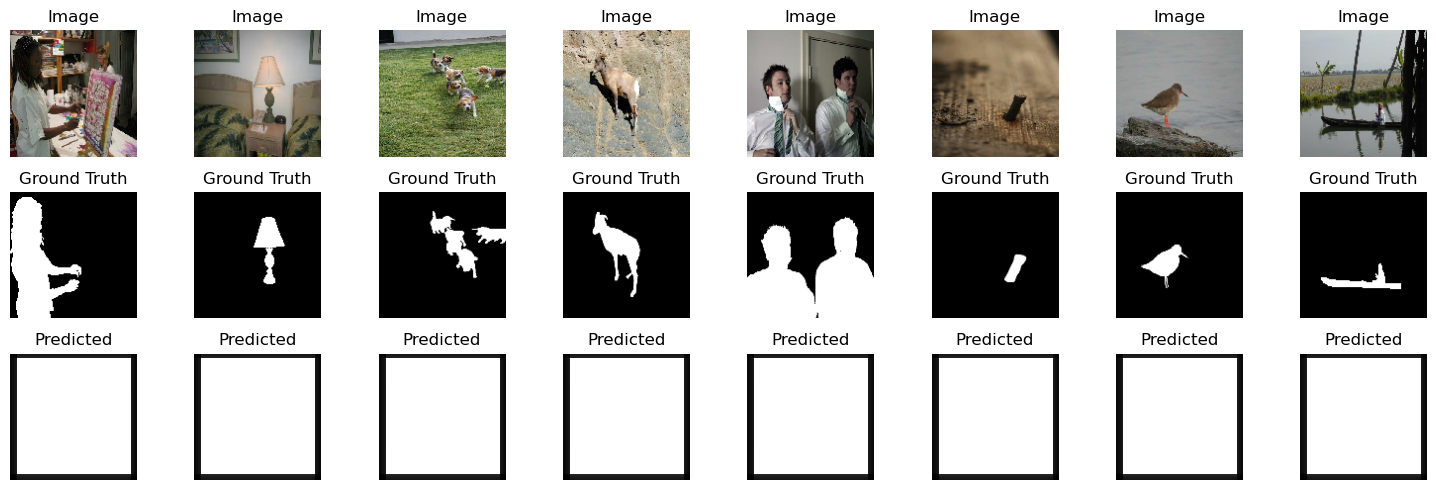

In [2]:
import matplotlib.pyplot as plt

# Predict on the test dataset
predictions = model.predict(test_dataset)


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def visualize_predictions(images, masks, outputs):
    images = images.numpy()  # Convert to numpy array if using TensorFlow
    masks = masks.numpy()    # Convert to numpy array if using TensorFlow
    outputs = tf.sigmoid(outputs).numpy()  # Apply sigmoid and convert to numpy

    num_images = len(images)
    fig, axs = plt.subplots(3, num_images, figsize=(15, 5))

    for i in range(num_images):
        # Original Image
        axs[0, i].imshow(images[i])
        axs[0, i].set_title('Image')
        axs[0, i].axis('off')
        
        # Ground Truth Mask
        axs[1, i].imshow(masks[i, :, :, 0], cmap='gray')
        axs[1, i].set_title('Ground Truth')
        axs[1, i].axis('off')
        
        # Predicted Mask
        axs[2, i].imshow(outputs[i, :, :, 0], cmap='gray')
        axs[2, i].set_title('Predicted')
        axs[2, i].axis('off')

    plt.tight_layout()
    plt.show()

# Define L1 loss (Mean Absolute Error)
loss_fn = tf.keras.losses.MeanAbsoluteError()

tf.random.set_seed(42)

# Assuming you have a test dataset and model loaded
for images, masks in test_dataset.take(1):  # Take a single batch
    outputs = model(images, training=False)  # Forward pass
    # Compute L1 loss
    loss = loss_fn(masks, outputs)

    # Visualize predictions
    visualize_predictions(images, masks, outputs)
    break  # Exit loop after first batch for visualization


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def save_images(images, masks, predictions, save_dir, batch_index):
    os.makedirs(save_dir, exist_ok=True)
    
    num_images = len(images)
    for i in range(num_images):
        fig, axs = plt.subplots(3, 1, figsize=(10, 15))
        
        # Original Image
        axs[0].imshow(images[i])
        axs[0].set_title('Image')
        axs[0].axis('off')
        
        # Ground Truth Mask
        axs[1].imshow(masks[i, :, :, 0], cmap='gray')
        axs[1].set_title('Ground Truth')
        axs[1].axis('off')
        
        # Predicted Mask
        axs[2].imshow(predictions[i, :, :, 0], cmap='gray')
        axs[2].set_title('Predicted')
        axs[2].axis('off')
        
        # Save the combined image
        combined_img_path = os.path.join(save_dir, f"combined_{batch_index * num_images + i}.png")
        plt.tight_layout()
        plt.savefig(combined_img_path)
        plt.close(fig)

save_dir = 'saved_imagesAutoBCE'

for batch_index, (images, masks) in enumerate(test_dataset):
    predictions = model(images, training=False)
    
    save_images(images.numpy(), masks.numpy(), tf.sigmoid(predictions).numpy(), save_dir, batch_index)

